# <span style="font-family: Arial, sans-serif; color:#97f788">xbooster</span>

## <span style="font-family: Arial, sans-serif; color:navyblue">LightGBM - Getting started</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Repo: <a href="https://github.com/xRiskLab/xBooster" title="GitHub link">https://github.com/xRiskLab/xBooster</a></span>


In [1]:
import sys
from pathlib import Path

# Get the absolute path to the project root directory
ROOT_DIR = str(Path().absolute().parent)
sys.path.append(ROOT_DIR)

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from scipy.special import expit as sigmoid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xbooster.lgb_constructor import LGBScorecardConstructor

%config InlineBackend.figure_format = 'retina'

In [3]:
# Load and prepare the data
data_path = Path("__file__").parent / "data" / "test_data_01d9ab8b.csv"
credit_data = pd.read_csv(str(data_path))
num_features = ["Gross_Annual_Income", "Application_Score", "Bureau_Score"]
categorical_features = ["Time_with_Bank"]
features = num_features + categorical_features

# Prepare X and y
X = credit_data[features]
y = credit_data["Final_Decision"].replace({"Accept": 0, "Decline": 1})

lgb_params = dict[str, float](
    n_estimators=10,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    verbose=-1,
)
model = LGBMClassifier(**lgb_params)

model.fit(X, y)

constructor = LGBScorecardConstructor(model, X, y)

print(f"Base score (log-odds): {constructor.base_score:.6f}")
print(f"Number of estimators: {constructor.n_estimators}")
print(f"Learning rate: {constructor.learning_rate}")
print(f"Max depth: {constructor.max_depth}")

Base score (log-odds): -2.199909
Number of estimators: 10
Learning rate: 0.1
Max depth: 3


/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_29996/1612785953.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = credit_data["Final_Decision"].replace({"Accept": 0, "Decline": 1})


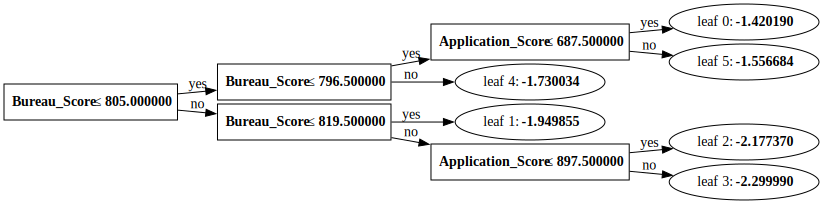

In [4]:
lgb.create_tree_digraph(model, tree_index=0, precision=6)

In [5]:
scorecard = constructor.construct_scorecard()
scorecard.query("Tree == 0")

,Tree,Node,Feature,Sign,Split,Count,CountPct,NonEvents,Events,EventRate,WOE,IV,XAddEvidence
0,0,0,Application_Score,<,687.5,35.0,0.028158,7.0,28.0,0.800000,3.586204,0.787354,-1.420190
1,0,1,Bureau_Score,<,819.5,37.0,0.029767,25.0,12.0,0.324324,1.465940,0.109114,-1.949855
2,0,2,Application_Score,<,897.5,175.0,0.140788,154.0,21.0,0.120000,0.207479,0.006584,-2.177370
3,0,3,Application_Score,>=,897.5,911.0,0.732904,902.0,9.0,0.009879,-2.407481,1.765878,-2.299990
4,0,4,Bureau_Score,>=,796.5,23.0,0.018504,11.0,12.0,0.521739,2.286921,0.198834,-1.730034
5,0,5,Application_Score,>=,687.5,62.0,0.049879,20.0,42.0,0.677419,2.941846,0.943852,-1.556684


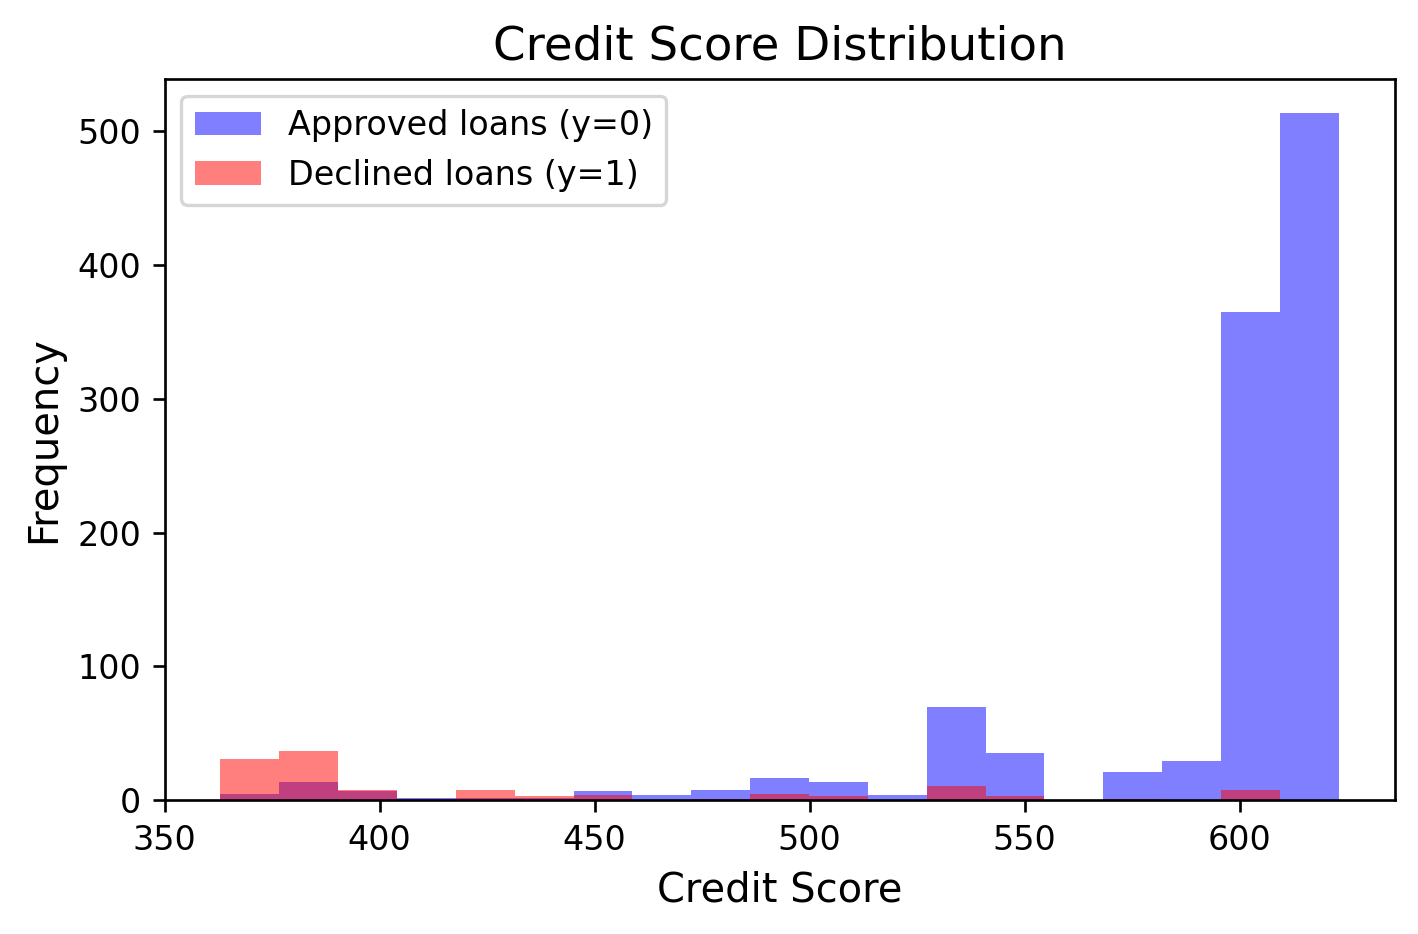

Gini of the scorecard: 0.9019
Gini of the model score: 0.9021


In [24]:
# Create scorecard with points
scorecard_with_points = constructor.create_points(
    pdo=50, target_points=600, target_odds=19, score_type="XAddEvidence", use_base_score=False
)

credit_scores = constructor.predict_score(X)

fig = plt.figure(figsize=(6, 4), dpi=120)
ax = fig.add_subplot(111)

# Create bins for the histogram
score_min, score_max = credit_scores.min(), credit_scores.max()
bins = np.linspace(score_min, score_max, 20)

# Plot score histograms by outcome
ax.hist(credit_scores[y == 0], bins=bins, color="blue", alpha=0.5, label="Approved loans (y=0)")
ax.hist(credit_scores[y == 1], bins=bins, color="red", alpha=0.5, label="Declined loans (y=1)")

ax.set_xlabel("Credit Score", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title(
    "Credit Score Distribution",
    fontsize=14,
)
ax.legend()
plt.tight_layout()
plt.show()

# Calculate ROC AUC score
gini_scorecard = roc_auc_score(y, -credit_scores) * 2 - 1
print(f"Gini of the scorecard: {gini_scorecard:.4f}")

gini_model = roc_auc_score(y, model.predict_proba(X)[:, 1]) * 2 - 1
print(f"Gini of the model score: {gini_model:.4f}")

## Logistic Regression on XAddEvidence


In [5]:
leaf_values = constructor.get_leafs(X, output_type="leaf_value")

lr_model = LogisticRegression(solver="newton-cg", penalty=None)
lr_model.fit(leaf_values, y)

print(f"Sample log odds: {np.log(y.mean()) - np.log(1 - y.mean()):.6f}")
print(f"Intercept: {lr_model.intercept_[0]:.6f}")
print(f"Coefficients: {lr_model.coef_[0]}")

avg_event_rate = y.mean()
print(f"Average event rate: {avg_event_rate:.6f}")

avg_pred_lr = lr_model.predict_proba(leaf_values)[:, 1].mean()
print(f"Average predicted probability (LR): {avg_pred_lr:.6f}")

avg_pred_lgb = model.predict_proba(X)[:, 1].mean()
print(f"Average predicted probability (LGB): {avg_pred_lgb:.6f}")

Sample log odds: -2.199909
Intercept: -3.034573
Coefficients: [-0.23317782  0.86731029  1.15097286  3.49255566  5.45792682  1.04165167
 -1.87229186  2.65109755  6.84930574  5.73859564]
Average event rate: 0.099759
Average predicted probability (LR): 0.099746
Average predicted probability (LGB): 0.102311


## Internal LightGBM booster

1. init_score should be the logit transform of your initial predictions.
2. The resulting Booster will predict logit offsets from your initial predictions (at least with the raw_score=True argument). To get the final probability predictions, add the original (logit-transformed) predictions, and then convert back into probability space with the inverse logit transform (i.e. scipy.special.expit below).

[When passing the init_score parameter to lightgbm for binary targets, do I pass my initial predictions as probabilities or as logit values?](https://stackoverflow.com/questions/65983746/when-passing-the-init-score-parameter-to-lightgbm-for-binary-targets-do-i-pass)


In [6]:
# Create internal LightGBM booster with init_score
base_score = np.log(y.mean()) - np.log(1 - y.mean())
base_score_vector = np.full(shape=y.shape, fill_value=base_score)
train_set = lgb.Dataset(X, y, init_score=base_score_vector)

internal_params = dict[str, float | str](
    # Your original params
    max_depth=3,
    learning_rate=0.1,
    seed=42,
    verbosity=-1,
    # Missing sklearn defaults
    boosting_type="gbdt",
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    subsample=1.0,
    colsample_bytree=1.0,
    subsample_freq=0,
    # For binary classification
    objective="binary",  # sklearn sets this automatically
)

booster = lgb.train(internal_params, train_set)

first_leaf = round(booster.get_leaf_output(tree_id=0, leaf_id=0) + base_score, 4)
print(f"First tree, first leaf log-odds (with base score): {first_leaf:.6f}")

preds = booster.predict(X, raw_score=True) + base_score_vector
sigmoid(preds).mean()

First tree, first leaf log-odds (with base score): -1.420200


0.09986013108125215

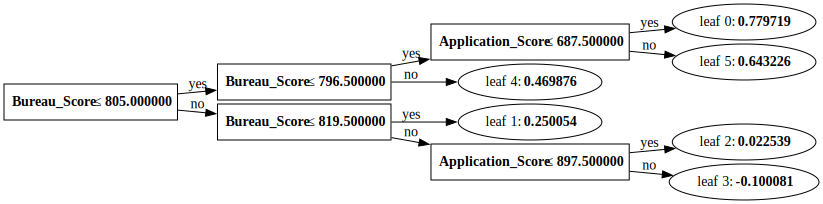

In [7]:
lgb.create_tree_digraph(booster, tree_index=0, precision=6)

In [8]:
# Get leaf indices for all trees
leaf_indices = booster.predict(X, pred_leaf=True)  # Shape: (n_samples, n_trees)

# Create a DataFrame to store leaf values
n_trees = booster.num_trees()
leaf_values = pd.DataFrame()

for tree_id in range(n_trees):
    # Get unique leaf indices for this tree
    unique_leaves = np.unique(leaf_indices[:, tree_id])

    leaf_map = {
        leaf_id: booster.get_leaf_output(tree_id, int(leaf_id)) for leaf_id in unique_leaves
    }
    # Map each sample to its leaf value
    leaf_values[f"tree_{tree_id}"] = [leaf_map[leaf_id] for leaf_id in leaf_indices[:, tree_id]]

# Now run logistic regression on the leaf values
lr_model = LogisticRegression(solver="newton-cg", penalty=None)
lr_model.fit(leaf_values, y)

print(f"Sample log odds: {np.log(y.mean() / (1 - y.mean())):.6f}")
print(f"Intercept: {lr_model.intercept_[0]:.6f}")
print(f"Coefficients: {lr_model.coef_[0]}")

avg_pred_lr = lr_model.predict_proba(leaf_values)[:, 1].mean()
print(f"Average predicted probability (LR): {avg_pred_lr:.6f}")

avg_pred_lgb = sigmoid(preds).mean()
print(f"Average predicted probability (LGB): {avg_pred_lgb:.6f}")

Sample log odds: -2.199909
Intercept: -23.064489
Coefficients: [   6.50127303   25.40880342   22.95593613    7.9183304    26.57266355
  -56.29064869   79.349195    -16.81540209   80.20789303  -39.29732968
  -61.99090026   31.18058166   -7.26929508  126.83679398   62.00252864
  -60.34463543  -82.86518776   53.83643569   -3.91676299  -67.19192154
  -67.3557007     1.14054547   93.5908287    98.31085068   81.59900157
   92.87747981   22.35125342   79.02445913   11.33564164  -58.44087572
   -1.27383422   56.01279064  -11.84186746  -44.66566079 -179.83568425
   92.92167687   49.79622503  -72.25277274 -114.89982251  -15.30765481
  -17.76118669  158.27009794 -102.37492421   -3.45550598  -59.19283365
  -26.7784933   -42.28740276   59.03844015  -63.09275377   33.73799602
   22.26284221   58.02397162   63.77570637   29.53398793   12.05731949
   51.70137655   87.46987809  -17.966306    -74.84294541  -19.89891204
  -25.82233937  141.82847296  -10.87602656  120.57934348   50.24082981
   55.0631532 